In [45]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from metal.mmtl.cxr.cxr_datasets import CXR8Dataset
from metal.mmtl.cxr.cxr_preprocess import transform_for_dataset

from torchvision import transforms
from PIL.ImageOps import equalize


import warnings
warnings.filterwarnings('ignore')

In [46]:
path_to_images = os.environ['CXR8IMAGES']
path_to_labels = os.path.join(os.environ['CXRDATA'],'CXR8-DRAIN-SLICE-DATA/CHEST_DRAIN')

In [70]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
res = 1024

    
# define torchvision transforms
data_transforms = transforms.Compose(
        [   
            #transforms.Lambda(lambda x: np.uint8(equalize_adapthist(np.array(x)))),
            #transforms.ToPILImage(),
            transforms.Lambda(lambda x: equalize(x)),
            transforms.Scale(res),
            transforms.CenterCrop(res),
            transforms.ToTensor(),
           # transforms.Normalize(mean, std),
        ]
)

In [71]:
# Creating datasets and dataloaders
splits = ['train', 'dev', 'test']
dataloaders = {}
for split in splits:
    dataset = CXR8Dataset(
        path_to_images,
        os.path.join(path_to_labels,f"{split}.tsv"),
        split,
        transform= data_transforms,#transform_for_dataset("CXR8",split,{'res':224}),
        subsample=0,
        finding="ALL",
        pooled=False,
        get_uid=False,
        slice_labels="DRAIN",
        single_task="DRAIN",
    )
    dataloaders[split] = DataLoader(dataset, **{'num_workers':16, 'batch_size': 16})

In [72]:
def get_preds_from_mod(Xs, mod):
    ys = []
    y_preds = []
    for ii, x in enumerate(Xs):
        y_pred = mod(X)
        y_preds.append(y_pred)
    return y_preds

In [73]:
# Creating new module for evaluation 
def DensitySliceModule(nn.Module):
    def forward(self,X):
        
    

SyntaxError: invalid syntax (<ipython-input-73-3b6597381a97>, line 2)

## SANDBOX

In [74]:
ds = dataloaders['train'].dataset

In [75]:
#[Xs, ys] = map(list, zip(*[(x['data'],y) for x,y in ds]))
Xs = torch.Tensor()
Ys = torch.Tensor()
for ii, batch, in enumerate(dataloaders['train']):
    if ii % 1 == 0:
        print(f"{ii} of {len(dataloaders['train'])} batches complete...")
    x,y = batch
    Xs = torch.cat((Xs,x['data']))
    Ys = torch.cat((Ys,y.float()))

0 of 28 batches complete...
1 of 28 batches complete...
2 of 28 batches complete...
3 of 28 batches complete...
4 of 28 batches complete...
5 of 28 batches complete...
6 of 28 batches complete...
7 of 28 batches complete...
8 of 28 batches complete...
9 of 28 batches complete...
10 of 28 batches complete...
11 of 28 batches complete...
12 of 28 batches complete...
13 of 28 batches complete...
14 of 28 batches complete...
15 of 28 batches complete...
16 of 28 batches complete...
17 of 28 batches complete...
18 of 28 batches complete...
19 of 28 batches complete...
20 of 28 batches complete...
21 of 28 batches complete...
22 of 28 batches complete...
23 of 28 batches complete...
24 of 28 batches complete...
25 of 28 batches complete...
26 of 28 batches complete...
27 of 28 batches complete...


In [77]:
Xs_pos = [x for ii,x in enumerate(Xs) if Ys[ii]==1]
Xs_neg = [x for ii,x in enumerate(Xs) if Ys[ii]==2]

In [78]:
import matplotlib.pyplot as plt
def get_histogram(xs, bins='auto'):
    Xs_flat_list = [x.flatten() for x in xs]
    Xs_flat = torch.cat(Xs_flat_list)
    n, bins, patches = plt.hist(x=Xs_flat, bins=bins, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    return Xs_flat, n, bins, patches

In [339]:
X_pos_flat, n_pos, bin_pos, patch_pos = get_histogram(Xs_pos)
X_neg_flat, n_neg, bin_neg, patch_neg  = get_histogram(Xs_neg, bins=bin_pos)

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd83a673518>>
Traceback (most recent call last):
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


AttributeError: 'str' object has no attribute 'flatten'

In [42]:
print(X_pos_flat.mean(),X_neg_flat.mean()) 

tensor(0.1169) tensor(0.2172)


In [79]:
from skimage.filters import roberts, sobel, scharr, prewitt
import cv2
import math

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

def canny_edge_detection(x, kwargs):
    x = np.array(x, dtype=np.uint8)
    x = x+np.min(x)
    return cv2.Canny(x, **kwargs)

def get_center_mask(small_size, large_size):
    B = np.zeros((large_size, large_size))
    nb = large_size
    na = small_size
    lower = int((nb) // 2 - (na // 2))
    upper = int((nb // 2) + (na // 2))
    print(lower, upper)
    B[lower:upper, lower:upper] = 1
    return B
    
def edge_detection(x,fn=roberts,mask_frac=0.8,large_size=224):
    mask_size = int(round_up_to_even(mask_frac*large_size))
    return fn(x,mask=get_center_mask(mask_frac, large_size))

def density_max_threshold(x,thresh):
    x = x.numpy()
    x = x-np.min(x)
    return (x>(thresh*np.max(x)))

def density_min_threshold(x,thresh):
    x = x.numpy()
    x = x-np.min(x)
    return (x<(thresh*np.max(x)))

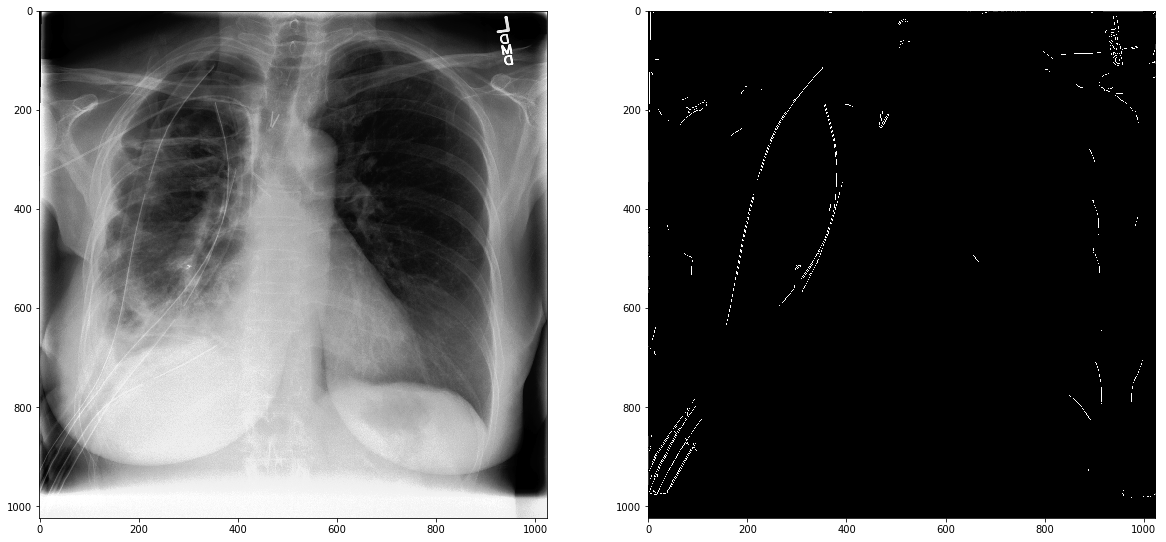

In [109]:
from functools import partial
from skimage.exposure import equalize_adapthist
ex_ind = 4 
#proc_fun = partial(density_max_threshold, thresh=0.3)
#proc_fun = partial(edge_detection, large_size=1024, mask_frac=0.8, fn=sobel)
# thresholds 100, 150 work well for non-mean-std data, 1024 res
proc_fun = partial(canny_edge_detection, kwargs={'threshold1':100, 'threshold2':150, 'apertureSize':3, 'L2gradient':True})

x_test = Xs_pos[ex_ind][0,:,:]
#x_test_eq = equalize_adapthist(x_test.numpy())
x_test_proc = proc_fun(x_test*255)

fig, ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(x_test, cmap='gray');
ax[1].imshow(x_test_proc, cmap='gray');

(0.0, 400000)

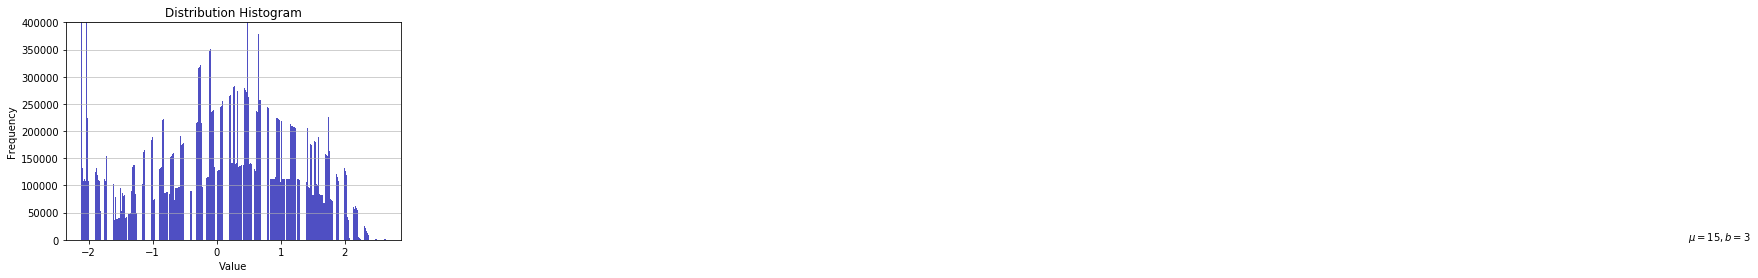

In [191]:
import matplotlib.pyplot as plt
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=Xs_flat, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=400000)

In [55]:
cv2.Canny(np.array(x_test, dtype=np.uint8), 100, 200, apertureSize=3, L2gradient=True)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [107]:
# Loading pretrained segnet (from https://github.com/imlab-uiip/lung-segmentation-2d)
from keras.models import load_model
from skimage import exposure, morphology

xx = (cv2.resize(x_test.numpy(), dsize=(256, 256))-mean[0])/std[0]
im_shape = xx.shape
xx = xx[None,:,:,None]
def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

model_name = '../../../../../../lung-segmentation-2d/trained_model.hdf5'
UNet = load_model(model_name)

img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
pred = UNet.predict(xx)[..., 0] #.reshape(inp_shape[:2])

pr = pred > 0.5

# Remove regions smaller than 2% of the image
pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

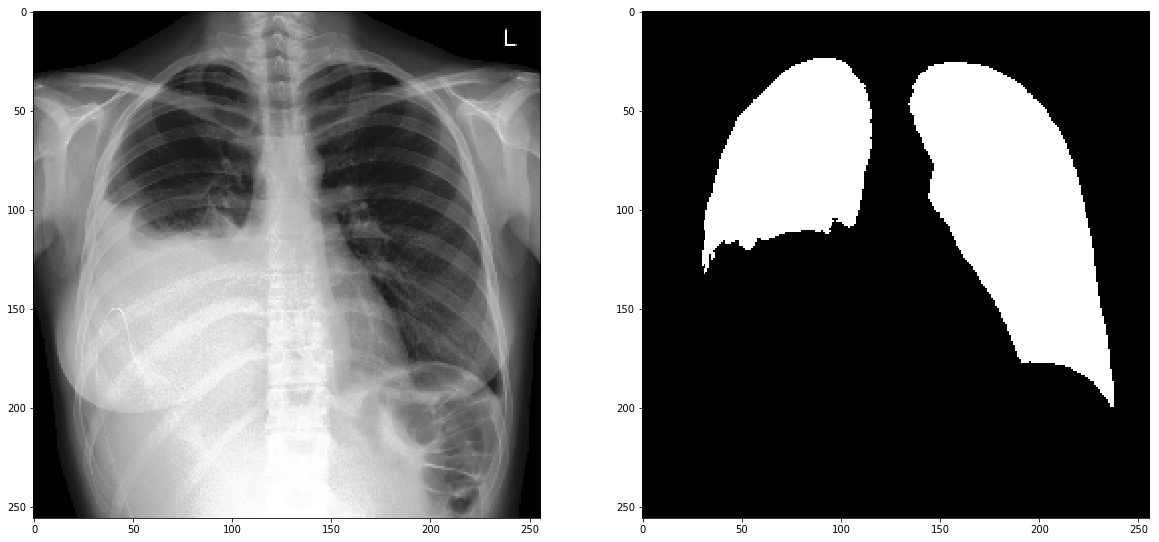

In [108]:
fig, ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(xx[0,:,:,0], cmap='gray');
ax[1].imshow(pr.squeeze(), cmap='gray');